In [1]:
!pip install rapidfuzz yfinance pandas numpy nltk scikit-learn matplotlib seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import json
import re
from collections import Counter

import numpy as np
import pandas as pd
import yfinance as yf

import nltk
from rapidfuzz import fuzz, process

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier


In [3]:
# load SEC(https://www.sec.gov/files/company_tickers.json) tickers
with open("tickers.json", "r") as f:
    tickers = json.load(f)
    companies = [tickers[i]["title"] for i in tickers]
    abbrs = [tickers[i]["ticker"] for i in tickers]

    comp_tckr = {comp: abbr for comp, abbr in zip(companies, abbrs)}

# load recall data
df = pd.read_csv("recalls.csv")

## Data Cleaning

In [4]:
# delete instances where year is older than 1995
print(len(df))
for i, row in df.iterrows():
    if ( row['Report Received Date'][-4:].isnumeric() and int(row['Report Received Date'][-4:]) < 1995 ):
        df.drop(i, inplace=True)
print(len(df))

29374
22505


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22505 entries, 0 to 23952
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Report Received Date                      22505 non-null  object 
 1   NHTSA ID                                  22505 non-null  object 
 2   Recall Link                               22505 non-null  object 
 3   Manufacturer                              22505 non-null  object 
 4   Subject                                   22505 non-null  object 
 5   Component                                 16196 non-null  object 
 6   Mfr Campaign Number                       22362 non-null  object 
 7   Recall Type                               22505 non-null  object 
 8   Potentially Affected                      22505 non-null  int64  
 9   Recall Description                        22500 non-null  object 
 10  Consequence Summary                    

In [6]:
# get set of common words to ignore
stop_words = set([
    "inc", "corp", "llc", "co", "ltd", "corporation",
    "company", "limited", "plc", "gmbh", "sa", "ag", "pte", "bv", "kg", "kgaa", "corp", "industries", "us", "of"
])

# create tokenizer
def tokenize(name):
    name = name.lower()
    name = re.sub(r'[^a-z0-9 ]', ' ', name) 
    words = name.split()
    return [w for w in words if w not in stop_words]

# build a word-to-company mapping
word_counts = Counter()
company_word_map = {}
for c in companies:
    words = tokenize(c)
    company_word_map[c] = set(words)
    word_counts.update(words)

# match company to ticker by unique words
def match_by_unique_words(name):
    words = tokenize(name)
    if not words:
        return None
    
    # score companies by sum of inverse word frequencies (rare words are more valuable)
    scores = {}
    for c, c_words in company_word_map.items():
        score = sum(1 / word_counts[w] for w in words if w in c_words)
        if score > 0:
            scores[c] = score
    
    if scores:
        return max(scores, key=scores.get)
    return None

df.loc[:22505, "fuzzy_company"] = df.loc[:22505, "Manufacturer"].apply(match_by_unique_words)

In [7]:
# get stock ticker
df["ticker"] = df["fuzzy_company"].map(comp_tckr)

# convert to datetime
df["Report Received Date"] = pd.to_datetime(df["Report Received Date"])

# get unique tickers
unique_tickers = df["ticker"].astype(str).unique().tolist()

# get all prices in range (start of day, end of day)
start_date = df["Report Received Date"].min()
end_date = df["Report Received Date"].max() + pd.Timedelta(days=1)
price_data = yf.download(unique_tickers, start=start_date, end=end_date, group_by="ticker", progress=False)

# helper function to grab pricing data
def get_price(ticker, date):
    try:
        day_data = price_data[ticker].loc[date.strftime("%Y-%m-%d")]
        return pd.Series([day_data["Open"], day_data["Close"]])
    except Exception:
        return pd.Series([None, None])

# get open/close price
df[["open", "close"]] = df.apply(lambda x: get_price(x["ticker"], x["Report Received Date"]), axis=1)

# grab info on ticker
info_cache = {}
for ticker in unique_tickers:
    try:
        t = yf.Ticker(ticker)
        info = t.info
        info_cache[ticker] = {
            "market_cap": info.get("marketCap"),
            "eps": info.get("trailingEps"),
            "full_name": info.get("longName"),
            "yearhigh": info.get("fiftyTwoWeekHigh"),
            "yearlow": info.get("firftyTwoWeekLow"),
            "volumnet": info.get("volume")
        }
    except Exception:
        pass

# merge info back on ticker
info_df = pd.DataFrame(info_cache).T
info_df.index.name = "ticker"
df = df.merge(info_df, on="ticker", how="left")


C:\Users\brand\AppData\Local\Temp\ipykernel_18036\1569765815.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(unique_tickers, start=start_date, end=end_date, group_by="ticker", progress=False)

44 Failed downloads:
['HCAC', 'NSNFY', 'ZSICY', 'RYPBF', 'TDWD', 'CFAC', 'MADL', 'TMRD', 'ODRS', 'METRY', 'AMPM', 'CLSO', 'LBRJ', 'BBAAY', 'EPDU', 'PLSAY', 'SEAH', 'LOMWF']: YFTzMissingError('possibly delisted; no timezone found')
['WSUPW', 'DC-WT', 'KII', 'RVSNW', 'XOSWW', 'ZAPWF', 'SPEGR', 'FFAIW', 'GRRRW', 'FBYDW', 'SKMTF', 'BKHAR', 'F-PD', 'AMBI-WT', 'OPTXW', 'GST', 'DSYWW', 'QTIWW', 'AMBP-WT', 'GROVW', 'CSC', 'AREBW', 'TGE-WT', 'HUBCZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 1995-01-01 00:00:00 -> 2025-10-02 00:00:00)')
['ALPS', 'PXED']: YFPricesMissingError('possibly delisted; no price data found  (1d 1995-01-01 00:00:00 -> 2025-10-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 7889

In [8]:
def ba_rm_nulls(df=None, col=None):
    """ 
    Helper function to print length of dataframe before removing nulls in a column, then print the length after the nulls are removed.

    Args:
        * df (pd.DataFrame): Dataframe with nulls.
        * col (str): Column name nulls should be removed from.

    Returns:
        * df (pd.DataFrame): Dataframe without nulls.
    """

    print(f"BEFORE NULLS FROM {col} REMOVED: ", len(df))

    df = df[df[f"{col}"].notna()]

    print(f"AFTER NULLS FROM {col} REMOVED: ", len(df))

    return df

In [9]:
df = ba_rm_nulls(df, "ticker")

BEFORE NULLS FROM ticker REMOVED:  22505
AFTER NULLS FROM ticker REMOVED:  16511


### Get Dummies

In [10]:
# see num of dummies from col types
print(len(df.value_counts("Recall Type")))
print(len(df.value_counts("Component")))

4
35


In [11]:
# fill missing components
df['Original_Component'] = df['Component'].fillna('')

In [12]:
# create dummies for recall and components
df = pd.get_dummies(data=df, prefix="RECALL_TYPE_", columns=["Recall Type"])
df = pd.get_dummies(data=df, prefix="COMPONENT_TYPE_", columns=["Component"])

### Bag of Words Featuring 

In [13]:
# init recall vectorizer
recall_vectorizer = CountVectorizer(
    input='content',    
    stop_words='english',
    analyzer='word',
    decode_error='ignore'
)

# init component vectorizer
component_vectorizer = CountVectorizer(
    input='content',    
    stop_words='english',
    analyzer='word',
    decode_error='ignore'
)

# init compnay response vectorizer
corrective_action_vectorizer = CountVectorizer(
    input='content',    
    stop_words='english',
    analyzer='word',
    decode_error='ignore'
)

In [14]:
# ensure component type is string
df["Original_Component"] = df["Original_Component"].astype(str)

In [15]:
# get bow for the diff cols
X_recall = recall_vectorizer.fit_transform(df["Recall Description"])
X_component = component_vectorizer.fit_transform(df["Original_Component"])
X_corrective_action = corrective_action_vectorizer.fit_transform(df["Corrective Action"])

In [16]:
df['Report Received Date'] = pd.to_datetime(df['Report Received Date'])

In [17]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

df["pct_of_yearly_max"] = np.clip(df["open"]/df["yearhigh"])
df["yearly_min_pct_of"] = np.clip(df["yearlow"] / df["open"], 0, 1)

N_COMPONENTS = 20   
K = 5          

# convert to dense matrix
X_recall_dense = X_recall.toarray()
X_component_dense = X_component.toarray()
X_corrective_dense = X_corrective_action.toarray()

# aplpy pca
pca = PCA(n_components=N_COMPONENTS, random_state=42)

X_recall_pca = pca.fit_transform(X_recall_dense)
X_component_pca = pca.fit_transform(X_component_dense)
X_corrective_pca = pca.fit_transform(X_corrective_dense)


def gmm_fixed_k(X, k=5, random_state=42):
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='diag',  
        random_state=random_state
    )
    labels = gmm.fit_predict(X)
    return gmm, labels


print("\nClustering Recall...")
recall_model, recall_labels = gmm_fixed_k(X_recall_pca, K)

print("Clustering Component...")
component_model, component_labels = gmm_fixed_k(X_component_pca, K)

print("Clustering Corrective Action...")
corrective_model, corrective_labels = gmm_fixed_k(X_corrective_pca, K)

# Add to df
df["recall_cluster"] = recall_labels
df["component_cluster"] = component_labels
df["corrective_action_cluster"] = corrective_labels


Clustering Recall...
Clustering Component...
Clustering Corrective Action...


In [18]:
# save for faster processing
df.to_csv('intermediate.csv')
df = pd.read_csv("intermediate.csv")

### Build Baseline Model

In [147]:
df = pd.read_csv("intermediate.csv")

In [150]:
df = df[df['Potentially Affected'] <=1000000] 

# stock market is generally in terms of %P/L. the reason being is who cares if i have 10 shares that are each $1000 and it moves a dollar
# in this case, i'd gain or lose $10.
# meanwhile, if i have 1000 shares at $10/each and it moves a dollar, i'd gain or lose $1000
df["pct_change"] = 100 * ((df["close"] - df["open"]) / df["open"])
df = df[(df["pct_change"] > -200) & (df["pct_change"] < 200) & df["pct_change"] != 0]

# determine target
y_NULL=df["pct_change"]

# features
X_NULL = df["Potentially Affected"].values

In [152]:
# split training and testing
X_train, X_test, y_train, y_test = train_test_split(X_NULL, y_NULL, test_size=0.2, random_state=24)

In [153]:
print("X_train_shape:", X_train.shape)
print("X_test_shape:", X_test.shape)
print("y_train_shape:", y_train.shape)
print("y_test_shape:", y_test.shape )

X_train_shape: (6504,)
X_test_shape: (1626,)
y_train_shape: (6504,)
y_test_shape: (1626,)


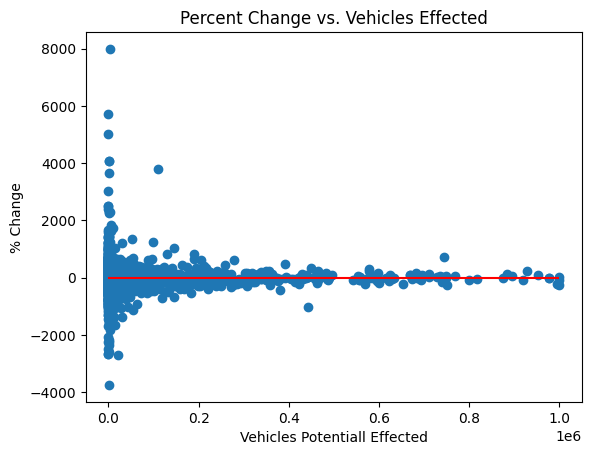

In [154]:
plt.scatter(X_NULL, y_NULL * 100)
plt.xlabel("Vehicles Potentiall Effected")
plt.ylabel("% Change")
plt.title("Percent Change vs. Vehicles Effected")
plt.hlines(y=0, xmin=0, xmax=1000000, linestyles='solid', colors="red")
plt.show()

In [155]:
# turn yes/no cols to be bools
cols_w_yn = ["Park Outside Advisory", "Do Not Drive Advisory"]
df[cols_w_yn] = df[cols_w_yn].replace({"Yes": 1, "No": 0})

# get engineered features
features = ["Potentially Affected", "Park Outside Advisory", "Do Not Drive Advisory", "market_cap", "eps"]
df[features] = df[features].astype(float).fillna(0)

C:\Users\brand\AppData\Local\Temp\ipykernel_18036\1908037100.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols_w_yn] = df[cols_w_yn].replace({"Yes": 1, "No": 0})


In [156]:
# scale cols with crazy magnitudes
scaler = StandardScaler()
non_bool_feats = ["Potentially Affected", "market_cap", "eps"]
df[non_bool_feats] = scaler.fit_transform(df[non_bool_feats])

# get features and target
X = df[features]
y = df['pct_change']

# split training and testing
X_train, X_test, y_train, y_test = train_test_split(X_NULL, y_NULL, test_size=0.2, random_state=24)


In [157]:
# train linear regression
lr = LinearRegression()
lr.fit(X, y)

# predict using linear regression
y_pred = lr.predict(X)

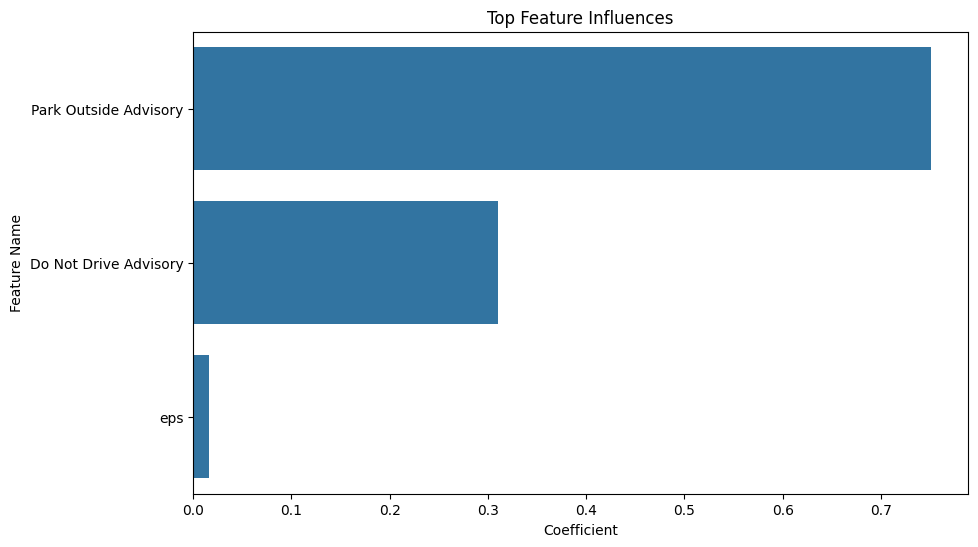

In [158]:
# get all feature coefficients from the trained model
coef_df = pd.DataFrame({
    'feature': features,
    'coef': lr.coef_
})

# plot values to see feature importances
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coef_df.head(3), x='abs_coef', y='feature')
plt.title("Top Feature Influences")
plt.xlabel("Coefficient")
plt.ylabel("Feature Name")
plt.show()


In [159]:
# get predictive metrics for evaluation
r2 = r2_score(y, y_pred)
print("R squared:", r2)


R squared: 0.00038380014004613106


In [160]:
pd.DataFrame({
    "y": y,
    "y_pred": y_pred
})

,y,y_pred
0,8.632281,-0.032049
2,0.566033,-0.018214
3,-1.294622,-0.018261
4,-6.435643,-0.018325
6,1.780617,-0.021473
...,...,...
16502,2.173906,-0.018489
16503,-1.410256,-0.018348
16504,-1.410256,-0.018343
16505,4.362416,-0.020862


### Can We Predict +/-?

In [162]:
# get features and target
X = df[features]
df["inc_dec"] = np.where(df["pct_change"] > 0, 1, 0)
y = df['inc_dec']

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [164]:
y_pred = np.zeros_like(y_test)

# get predictive metrics for evaluation
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.503690036900369


# Model Specification

## Random Forest Regressor

In [165]:
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [166]:
rf = RandomForestRegressor(random_state=24)

In [167]:
features = [
    "Potentially Affected",
    "Park Outside Advisory",
    "Do Not Drive Advisory",
    "market_cap",
    "eps",
    "pct_of_yearly_max"
] + [col for col in df.columns if col.startswith(('COMPONENT_TYPE', 'RECALL_TYPE')) or col.endswith('cluster')]

# fill missing for base features
df[features] = df[features].astype(float).apply(lambda col: col.fillna(col.mean()))

# final feature matrix
X = df[features]
y = df["pct_change"]



In [168]:
# split training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [75]:
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=42,
)

rf_random.fit(X_train, y_train)

KeyboardInterrupt: 

In [169]:
# print("Best hyperparameters:", rf_random.best_params_)
# print("Best CV R squared:", rf_random.best_score_)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MSE:", mse)
print("Test R squared:", r2)

Test MSE: 14.306917149817984
Test R squared: -0.10016764445946325


In [170]:
from sklearn.tree import DecisionTreeClassifier
# binary target: up (1) or down (0)
y_train_cls = (y_train > 0).astype(int)
y_test_cls  = (y_test > 0).astype(int)

tree_clf = DecisionTreeClassifier(random_state=24)

tree_clf.fit(X_train, y_train_cls)

y_pred_cls = tree_clf.predict(X_test)

acc = accuracy_score(y_test_cls, y_pred_cls)

print("Decision Tree Accuracy:", acc)


Decision Tree Accuracy: 0.5313653136531366
